# Proof of Concept: Inverse Transforms for Forecasters

100%|██████████| 414/414 [00:00<00:00, 861.84it/s]


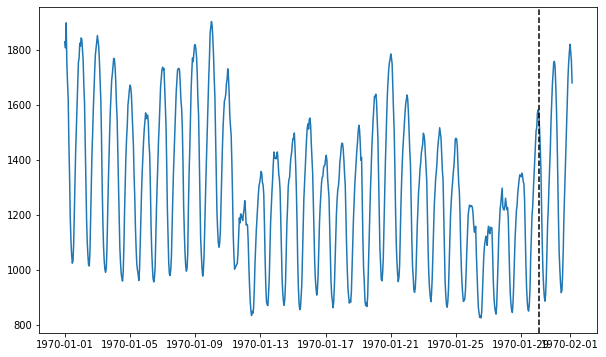

In [1]:
import matplotlib.pyplot as plt

from merlion.utils import TimeSeries
from ts_datasets.forecast import M4

ts, md = M4(subset="Hourly")[2]
train = TimeSeries.from_pd(ts[md["trainval"]])
test = TimeSeries.from_pd(ts[~md["trainval"]])

ax = plt.figure(figsize=(10, 6)).add_subplot(111)
ax.plot(ts)
ax.axvline(train.to_pd().index[-1], ls="--", c="k")
plt.show()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from merlion.evaluate.forecast import ForecastMetric
from merlion.models.forecast.base import ForecasterBase
from merlion.models.forecast.prophet import Prophet, ProphetConfig
from merlion.transform.resample import TemporalResample
from merlion.transform.sequence import TransformSequence
from merlion.utils import TimeSeries

def get_model(transform=None):
    if transform is not None:
        transform = TransformSequence([TemporalResample(), transform])
    prophet = Prophet(ProphetConfig(add_seasonality="auto", transform=transform))
    return prophet

def eval_model(model: ForecasterBase, train_data: TimeSeries, test_data: TimeSeries,
               apply_inverse=True):
    og_train = train_data
    model.config.invert_transform = apply_inverse
    yhat_train, _ = model.train(train_data)
    if not apply_inverse:
        train_data = model.transform(train_data)
    
    t = test_data.time_stamps
    yhat_test, _ = model.forecast(t)
    if not apply_inverse:
        test_data = model.transform(og_train + test_data).align(reference=t)
    
    print(f"Train sMAPE: {ForecastMetric.sMAPE.value(train_data, yhat_train):.2f}")
    print(f"Test  sMAPE: {ForecastMetric.sMAPE.value(test_data, yhat_test):.2f}")

    ax = plt.figure(figsize=(10, 6)).add_subplot(111)
    ax.plot((train_data + test_data).to_pd(), label="true")
    ax.plot((yhat_train + yhat_test).to_pd(), label="model")
    ax.axvline(pd.to_datetime(t[0], unit="s"), c="k", ls="--")
    ax.legend()
    plt.show()
    return yhat_test

21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing


No transform...
Train sMAPE: 4.88
Test  sMAPE: 17.58


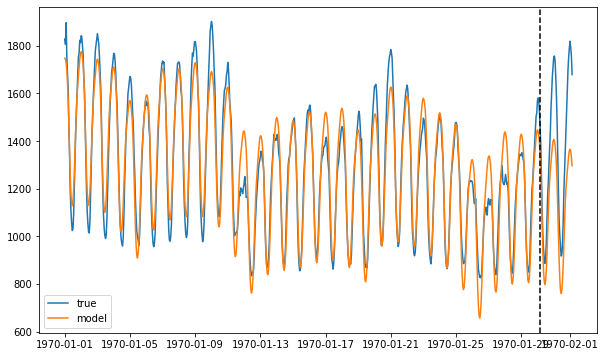

In [3]:
print("No transform...")
base = eval_model(get_model(), train, test, apply_inverse=True)

Normalize...


21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing


Train sMAPE: 54.41
Test  sMAPE: 118.27


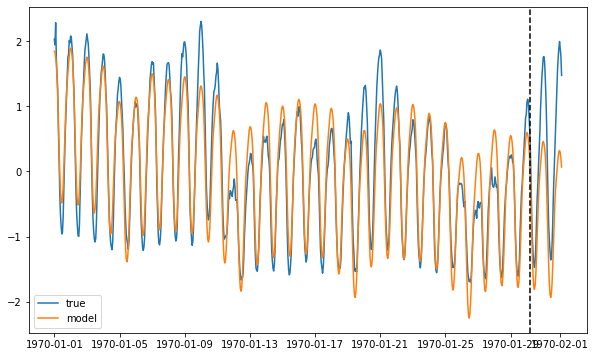

Normalize + invert...


21:14:27 - cmdstanpy - INFO - Chain [1] start processing
21:14:27 - cmdstanpy - INFO - Chain [1] done processing


Train sMAPE: 5.73
Test  sMAPE: 17.55


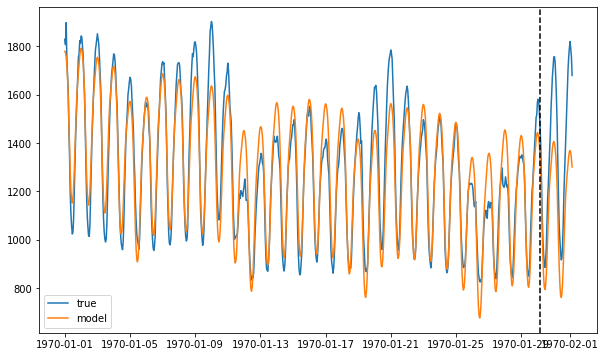

In [4]:
from merlion.transform.normalize import MeanVarNormalize, MinMaxNormalize

print("Normalize...")
eval_model(get_model(MeanVarNormalize()), train, test, apply_inverse=False)

print("Normalize + invert...")
norm = eval_model(get_model(MeanVarNormalize()), train, test, apply_inverse=True)

Box-Cox transform...


21:14:27 - cmdstanpy - INFO - Chain [1] start processing
21:14:27 - cmdstanpy - INFO - Chain [1] done processing


Train sMAPE: 0.99
Test  sMAPE: 3.36


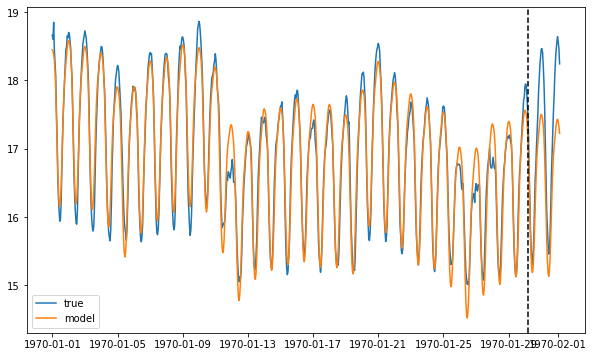

Box-Cox transform + invert...


21:14:28 - cmdstanpy - INFO - Chain [1] start processing
21:14:28 - cmdstanpy - INFO - Chain [1] done processing


Train sMAPE: 3.61
Test  sMAPE: 12.30


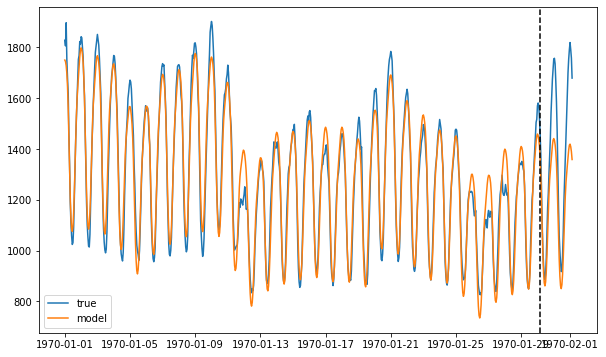

In [5]:
from merlion.transform.normalize import BoxCoxTransform

print("Box-Cox transform...")
eval_model(get_model(BoxCoxTransform()), train, test, apply_inverse=False)

print("Box-Cox transform + invert...")
boxcox = eval_model(get_model(BoxCoxTransform()), train, test, apply_inverse=True)

Moving Average...


21:14:29 - cmdstanpy - INFO - Chain [1] start processing
21:14:29 - cmdstanpy - INFO - Chain [1] done processing


Train sMAPE: 4.46
Test  sMAPE: 17.09


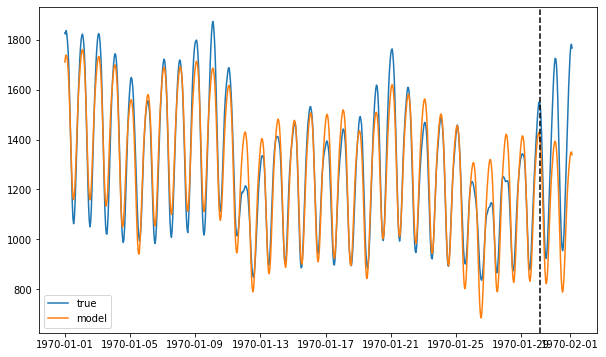

Moving Average + invert...


21:14:29 - cmdstanpy - INFO - Chain [1] start processing
21:14:29 - cmdstanpy - INFO - Chain [1] done processing


Train sMAPE: 5.49
Test  sMAPE: 17.88


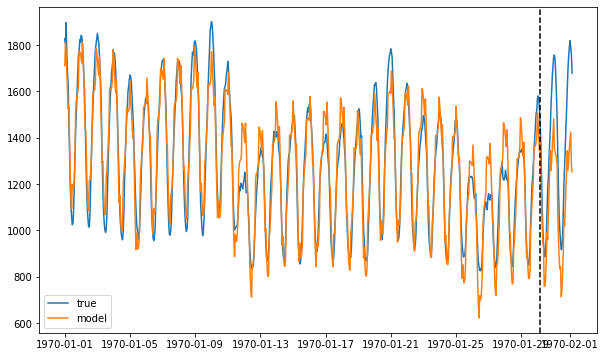

In [6]:
from merlion.transform.moving_average import MovingAverage

print("Moving Average...")
eval_model(get_model(MovingAverage(n_steps=5)), train, test, apply_inverse=False)

print("Moving Average + invert...")
ma = eval_model(get_model(MovingAverage(n_steps=5)), train, test, apply_inverse=True)

Difference transform...

21:14:30 - cmdstanpy - INFO - Chain [1] start processing
21:14:30 - cmdstanpy - INFO - Chain [1] done processing



Train sMAPE: 53.17
Test  sMAPE: 48.12


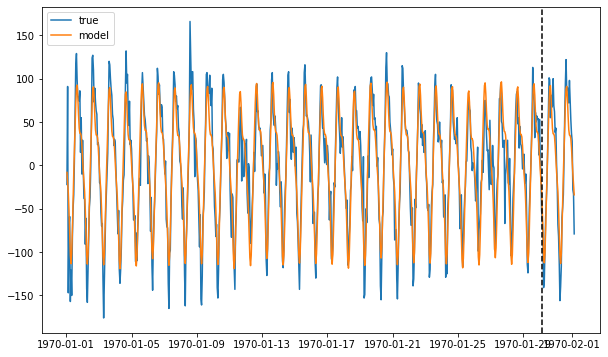

Difference transform + invert...


21:14:30 - cmdstanpy - INFO - Chain [1] start processing
21:14:30 - cmdstanpy - INFO - Chain [1] done processing


Train sMAPE: 6.47
Test  sMAPE: 19.18


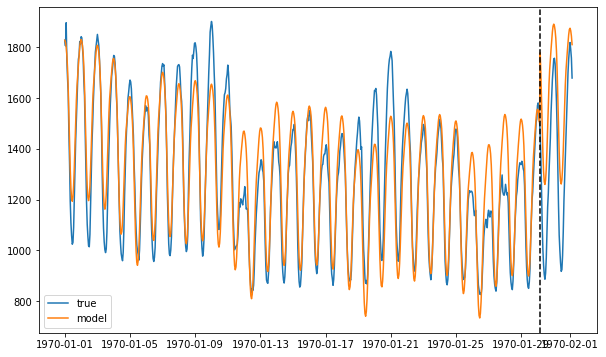

In [7]:
from merlion.transform.moving_average import DifferenceTransform

print("Difference transform...")
eval_model(get_model(DifferenceTransform()), train, test, apply_inverse=False)

print("Difference transform + invert...")
diff = eval_model(get_model(DifferenceTransform()), train, test, apply_inverse=True)

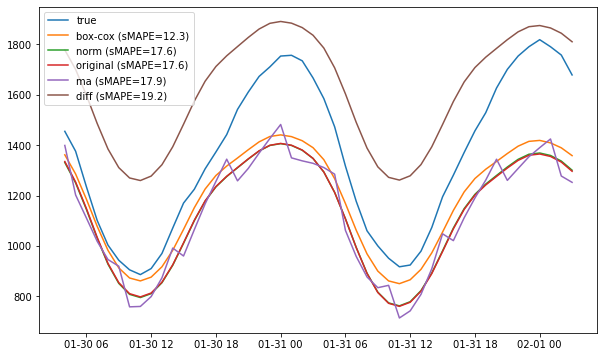

In [8]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(test.to_pd(), label="true")
series = [("original", base), ("norm", norm), ("box-cox", boxcox), ("ma", ma), ("diff", diff)]
smapes = {name: ForecastMetric.sMAPE.value(test, ts) for name, ts in series}

for name, ts in sorted(series, key=lambda ns: smapes[ns[0]]):
    smape = smapes[name]
    if smape <= max(50, sorted(smapes.values())[:2][-1]):
        ax.plot(ts.to_pd(), label=f"{name} (sMAPE={smape:.1f})")
ax.legend()
plt.show()